In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.losses import CategoricalCrossentropy 
import sys

def column_one_hot (dataframe, columns): 
    for column in columns:
        if column in dataframe:
            one_hot = pd.get_dummies(dataframe[column])
            dataframe = dataframe.drop(column,axis = 1)
            dataframe = pd.concat([dataframe, one_hot], axis=1)
    return dataframe

def drop_columns (dataframe, columns):
    for column in columns:
        if column in dataframe.columns:
            dataframe = dataframe.drop(column, axis=1)
    return dataframe

def drop_column (dataframe, column):
    if column in dataframe.columns:
        dataframe = dataframe.drop(column, axis=1)
    return dataframe

In [70]:
df = pd.read_csv('SAR_Data.csv')
df.shape

status = df['Status'].unique()
for x in status:
    print(x + " " + str(len(df[df['Status'] == x])))

print ("----------------------------------------------------------------")

maskOpen = ((df['Status'] == 'postponed') | (df['Status'] == 'partly open') |( df['Status'] == 'In creation'))
maskClosed = (df['Status'] == 'partly closed')
df.loc[maskOpen, 'Status'] = 'open'
df.loc[maskClosed, 'Status'] = 'closed'
df.loc[(df['Status'] == 'non applicable'), 'Status'] = 'not applicable'
status = df['Status'].unique()
for x in status:
    print(x + " " + str(len(df[df['Status'] == x])))

# postponed, partly open, in creation -> open;    partly closed -> closed

In creation 773
non applicable 4052
closed 6772
forwarded 1339
open 111
postponed 12
compliant 1413
partly closed 92
partly open 8
----------------------------------------------------------------
open 904
not applicable 4052
closed 6864
forwarded 1339
compliant 1413


([<matplotlib.patches.Wedge at 0x1ae0ffeb880>,
 [Text(1.0791749596761293, 0.2130291210328414, 'open'),
  Text(0.33287410392687333, 1.0484249286119065, 'not applicable'),
  Text(-0.978140167763154, -0.5032313704532628, 'closed'),
  Text(0.6855473250388082, -0.8602469791473464, 'forwarded'),
  Text(1.049353730597924, -0.32993446027994694, 'compliant')],
 [Text(0.5886408870960704, 0.11619770238154983, '6.2%'),
  Text(0.1815676930510218, 0.5718681428792216, '27.8%'),
  Text(-0.533531000598084, -0.2744898384290524, '47.1%'),
  Text(0.3739349045666226, -0.46922562498946163, '9.2%'),
  Text(0.5723747621443221, -0.1799642510617892, '9.7%')])

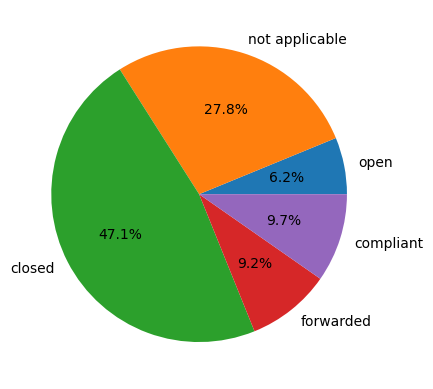

In [71]:
status = df['Status'].unique()
hauefigkeit = []
for x in status:
    hauefigkeit.append(len(df[df['Status'] == x]))
fig, ax = plt.subplots()
ax.pie(hauefigkeit, labels=status, autopct='%1.1f%%')

In [72]:
# falsche Ordnerstruktur in /RA Application Conditions/03_PG_OCS/Service and diagnostic systems
# fehlt ein Ordner bevor Module kommen, deshalb händisch eintragen

df.loc[df['Version'].str.contains('VICOS_S_D'), 'Product'] = 'VICOS_S_D'
df.loc[df['Version'].str.contains('VICOS_S_D'), 'Version'] = df['Version'].str[-5:]

In [47]:
print(df['Product'].unique())
df[df['Product'] == "/"].shape

['DCM' 'ACM300' 'Trainguard 200 RBC' 'SICAS ECC' 'SIMIS IS'
 'ETCS Engineering Process' 'CG ETCS Workstation' 'AzS350U' 'TGMT'
 'ACM200' 'Clearguard TCM 100' 'VICOS OC111' 'LED_70_at_Som6'
 'LED_Anzeigemodul' 'LEU S21 MS MC MT 208-233_-433_-533'
 'Eurobalise S21 und S22' 'SIMIS W' 'VICOS NCU' 'LED_70' 'LED_136'
 'POM4 S700K BSG9' 'Key Switch' 'VICOS OC501' 'LZB700M' 'VICOS_S_D'
 'LEU S21 MS MC MT 208-203_-403_-503' 'Eurobalise S21' '/' 'DTS'
 'SIMIS LC' 'AC100' 'LEU S21 M ME 208-201_-401']


(147, 6)

In [73]:
paths = df['Path'].unique()
accessDB = pd.read_xml("X:/File/DE/bwga024a_IMORA_RM/05_Process_Management/14_Metriken & KPI/KPI-Erhebung/KPI_01-04_General/Data/Input/Input_BWG_Combined_Access.xml")

for path in paths:
    try:
        if(path == "/ML Realization Projects Algeria"):
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & (accessDB['Offset'] == "/ML Realization Projects Algeria/20006_ML_BM_Boughezoul_MSila")].iloc[0]
        else:
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & ((accessDB['Offset'] == str(path)) | (accessDB['Offset'] == (str(path) + "/")))].iloc[0]           
    except:
        print(str(path) + " has no entry in the AccessDB!")

    mask = df['Path'] == str(path)
    df.loc[mask, 'Project_category'] = result['Project_category']
    df.loc[mask, 'BS'] = result['BS']
    df.loc[mask, 'RU'] = result['RU']
    df.loc[mask, 'ProjectYear'] = result['ProjectYear']
    df.loc[mask, 'section'] = result['section']
    df.loc[mask, 'Project_name'] = result['Project_name']
    df['ProductVersion'] = df["Product"].str.cat(df["Version"], sep = "-")

df['ProjectYear'] = df['ProjectYear'].astype('int')
df = df[['Text', 'Product', 'ProductVersion', 'Project_name', 'section', 'Project_category', 'BS', 'RU', 'ProjectYear', 'Status', 'Statement']]
#df = drop_column(df, 'Statement') # später wieder löschen!
df.head()
df.shape


(14572, 11)

In [74]:
text = df['Text'].value_counts()
eins = 0
for anzahl in text:
    if anzahl == 1:
        eins += 1
print ("Anzahl Anwendungsregeln, welche nur einmal bewertet wurden: " + str(eins))
print ("Anteil am Datensatz: " + str(round(round(eins/df.shape[0], 4) * 100, 2)) + "%")
    
#text.head(10)
test = df.loc[df['Text'] == "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."]
test.reset_index(inplace=True, drop=True)
test.head(17)

Anzahl Anwendungsregeln, welche nur einmal bewertet wurden: 4198
Anteil am Datensatz: 28.81%


,Text,Product,ProductVersion,Project_name,section,Project_category,BS,RU,ProjectYear,Status,Statement
0,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W20,KR Incheon Songdo,BS MassTransit,C,MT,HQ,2018,not applicable,DC_POM modules are not used in the SDO7 projec...
1,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-S23_1,TR Istanbul L4,BS MassTransit,C,MT,HQ,2014,not applicable,Für das Projekt Istanbul Metro Linie 1 und 4 n...
2,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W20,IN Chennai,BS MassTransit,B,MT,HQ,2011,closed,During the commissioning the rule will be che...
3,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W20,IN Chennai,BS MassTransit,B,MT,HQ,2011,not applicable,According to the circuit diagrams STG A6Z0004...
4,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W16,TR Istanbul L4,BS MassTransit,C,MT,HQ,2014,closed,Es wurden Signalkabel nach VDE0816/2 bzw. mit ...
5,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W16,TR Istanbul L4,BS MassTransit,C,MT,HQ,2014,not applicable,Dieses Requirement ist für das Projekt Istanbu...
6,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W18_1,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,Zur Anschaltung der Weichen in der Außenanlage...
7,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-W18_1,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,In diesem Projekt wird die DC-POM nicht einges...
8,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-S29,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,Im Projekt BALH sind die Signalkabel nach VDE...
9,Zur Anschaltung des Antriebes in der Außenanla...,SICAS ECC,SICAS ECC-Spemom 4.1,AR Buenos Aires Line H,BS MassTransit,C,MT,HQ,2012,compliant,Zur Anschaltung der Fahrsperren in der Außenan...


In [50]:
df['Text'].value_counts()

Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   17
Auf einer Kundenanlage darf nur ein Betriebssystem (inklusive aller Dienste  Treiber  Konfigurationsdateien und Einstellungen) eingesetzt werden  das zuvor einer Typprüfung zur Verfahrenssicherheit unterzogen wurde. Der Bezug auf die durchgeführte Typp

In [51]:
print(df['Product'].unique())
testdf = df[df['Product'] == "/"]
testdf.shape
# '/57022-ML-HU-Szazhalombatta-Pusztaszabolcs' hat keinen Link auf RA Application Conditions sondern nur zu einem Modul in einem anderen Projekt aus Ungarn
# '/55525_ML_HU_KLBA' hat teilweise keinen Link auf RA Application Conditions

## Hoffentlich gefixt, Update: nur teilweise gefixt, 147 Objekte immernoch keinen Link auf RA Application Conditions

['DCM' 'ACM300' 'Trainguard 200 RBC' 'SICAS ECC' 'SIMIS IS'
 'ETCS Engineering Process' 'CG ETCS Workstation' 'AzS350U' 'TGMT'
 'ACM200' 'Clearguard TCM 100' 'VICOS OC111' 'LED_70_at_Som6'
 'LED_Anzeigemodul' 'LEU S21 MS MC MT 208-233_-433_-533'
 'Eurobalise S21 und S22' 'SIMIS W' 'VICOS NCU' 'LED_70' 'LED_136'
 'POM4 S700K BSG9' 'Key Switch' 'VICOS OC501' 'LZB700M' 'VICOS_S_D'
 'LEU S21 MS MC MT 208-203_-403_-503' 'Eurobalise S21' '/' 'DTS'
 'SIMIS LC' 'AC100' 'LEU S21 M ME 208-201_-401']


(147, 11)

In [52]:
products = df['Product'].unique()
df_product = column_one_hot(df[['Product']], ['Product'])
projects = df['Project_name'].unique()
for project in projects:
    for product in products:
        df_product.loc[df['Project_name'] == project, product] = 1 if (df_product.loc[df['Project_name'] == project][product].sum()) >= 1 else 0
if (not (products[0] in df)):        
    df = df.join(df_product)
df = drop_column(df, 'Product')
df = column_one_hot(df, ['ProductVersion', 'Project_name', 'section',
       'Project_category', 'BS', 'RU', 'ProjectYear'])
df.head()

,Text,Status,Statement,/,AC100,ACM200,ACM300,AzS350U,CG ETCS Workstation,Clearguard TCM 100,...,2009,2011,2012,2013,2014,2015,2017,2018,2019,2020
0,The equipment described may only be used with...,open,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Equalize the charge before inserting the xCM....,open,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,In order to avoid unnecessary aging of the spa...,open,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,The DCM must be mounted on a mounting unit. If...,open,TERMINATE Covered by [REF PAC_DigIO_2980],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Dispose of faulty electronic circuit boards r...,open,TERMINATE Maintenance DCM 300 A6Z00050460843...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text]
df_training.reset_index(inplace=True, drop=True)

test_col = 12
test = drop_columns(df_training.iloc[[test_col]], ['Text', 'Status', 'Statement'])
df_training = df_training.drop(test_col)

In [54]:
trainX = drop_columns(df_training, ['Status', 'Text', 'Statement'])
trainYStatus = drop_column(column_one_hot(df_training[['Text', 'Status']], ['Status']), "Text")
trainYStatement = drop_column(column_one_hot(df_training[['Text', 'Statement']], ['Statement']), "Text")

In [55]:
modelStatus = Sequential()
modelStatus.add(Input(shape=trainX.shape[1]))
modelStatus.add(Dense(16, activation='relu'))
modelStatus.add(Dense(trainYStatus.shape[1], activation='softmax'))
modelStatus.summary()
modelStatus.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

history = modelStatus.fit(trainX, trainYStatus,
                    batch_size=2,
                    epochs=50,
                    verbose=2,
                    validation_split=0.4)

modelStatement = Sequential()
modelStatement.add(Input(shape=trainX.shape[1]))
modelStatement.add(Dense(16, activation='relu'))
modelStatement.add(Dense(trainYStatement.shape[1], activation='softmax'))
modelStatement.summary()
modelStatement.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

history = modelStatement.fit(trainX, trainYStatement,
                    batch_size=2,
                    epochs=50,
                    verbose=2,
                    validation_split=0.4)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                2848      
                                                                 
 dense_9 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2,899
Trainable params: 2,899
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 2s - loss: 1.1808 - accuracy: 0.4444 - val_loss: 0.9565 - val_accuracy: 0.7143 - 2s/epoch - 323ms/step
Epoch 2/50
5/5 - 0s - loss: 1.1390 - accuracy: 0.4444 - val_loss: 0.9619 - val_accuracy: 0.7143 - 101ms/epoch - 20ms/step
Epoch 3/50
5/5 - 0s - loss: 1.1054 - accuracy: 0.4444 - val_loss: 0.9701 - val_accuracy: 0.7143 - 85ms/epoch - 17ms/step
Epoch 4/50
5/5 - 0s - loss: 1.0764 - accuracy: 0.4444 - val_loss: 0.9769 - val_accur

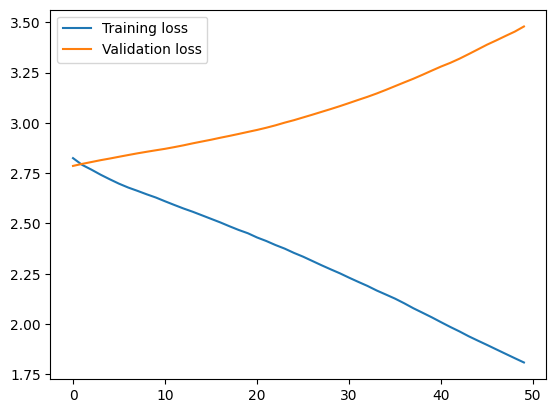

In [56]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [57]:
predictionStatus = modelStatus.predict(test)
col = 0
for i in predictionStatus:
    for j in i:
        print (trainYStatus.columns[col] + " " + '{:.1%}'.format(j))
        col += 1

print ("-----------------------------------------------------")

predictionStatement = modelStatement.predict(test)
index_max = np.argmax(predictionStatement)
print (trainYStatement.columns[index_max] + " " + '{:.1%}'.format(predictionStatement[0][index_max]))
#col = 0
#for i in predictionStatement:
#    for j in i:
#        print (trainYStatement.columns[col] + " " + '{:.1%}'.format(j))
#        col += 1
#

1/1 [==============================] - 0s 78ms/step
closed 33.6%
compliant 33.7%
not applicable 32.7%
-----------------------------------------------------
1/1 [==============================] - 0s 95ms/step
 Im Projekt BALH sind die Signalkabel nach VDE0816/2 verwendet. Die Verlegevorschriften des Kabels sind beim Verlegen eingehalten.  Daher ist diese Auflage erfüllt.  Bitte sieh  Kabelspezifikation (Aussenkabel)  A6Z00038004325  -  Outdoor Cable Plan  A6Z00037954383  -  9.8%


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.losses import CategoricalCrossentropy 
import sys

#df = pd.read_csv('c:/Users/z0044ber/Desktop/Ostfalia/Bachelorarbeit/Bachelorarbeit/Code/Working/SAR_training.csv')
modelStatus = Sequential()
modelStatement = Sequential()

def column_one_hot (dataframe, columns): 
    for column in columns:
        if column in dataframe:
            one_hot = pd.get_dummies(dataframe[column])
            dataframe = dataframe.drop(column,axis = 1)
            dataframe = pd.concat([dataframe, one_hot], axis=1)
    return dataframe

def drop_columns (dataframe, columns):
    for column in columns:
        if column in dataframe.columns:
            dataframe = dataframe.drop(column, axis=1)
    return dataframe

def drop_column (dataframe, column):
    if column in dataframe.columns:
        dataframe = dataframe.drop(column, axis=1)
    return dataframe

def fixMistakes(df):
    maskOpen = ((df['Status'] == 'postponed') | (df['Status'] == 'partly open') |( df['Status'] == 'In creation'))
    maskClosed = (df['Status'] == 'partly closed')
    df.loc[maskOpen, 'Status'] = 'open'
    df.loc[maskClosed, 'Status'] = 'closed'
    df.loc[(df['Status'] == 'non applicable'), 'Status'] = 'not applicable'

    df.loc[df['Version'].str.contains('VICOS_S_D'), 'Product'] = 'VICOS_S_D'
    df.loc[df['Version'].str.contains('VICOS_S_D'), 'Version'] = df['Version'].str[-5:]
    return df

def gatherData(df):
    #global df
    paths = df['Path'].unique()
    accessDB = pd.read_xml("X:/File/DE/bwga024a_IMORA_RM/05_Process_Management/14_Metriken & KPI/KPI-Erhebung/KPI_01-04_General/Data/Input/Input_BWG_Combined_Access.xml")

    for path in paths:
        try:
            if(path == "/ML Realization Projects Algeria"):
                result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & (accessDB['Offset'] == "/ML Realization Projects Algeria/20006_ML_BM_Boughezoul_MSila")].iloc[0]
            else:
                result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & ((accessDB['Offset'] == str(path)) | (accessDB['Offset'] == (str(path) + "/")))].iloc[0]           
        except:
            print(str(path) + " has no entry in the AccessDB!")

        mask = df['Path'] == str(path)
        df.loc[mask, 'Project_category'] = result['Project_category']
        df.loc[mask, 'BS'] = result['BS']
        df.loc[mask, 'RU'] = result['RU']
        df.loc[mask, 'ProjectYear'] = result['ProjectYear']
        df.loc[mask, 'section'] = result['section']
        df.loc[mask, 'Project_name'] = result['Project_name']
        df['ProductVersion'] = df["Product"].str.cat(df["Version"], sep = "-")

    df['ProjectYear'] = df['ProjectYear'].astype('int')
    df = df[['Text', 'Product', 'ProductVersion', 'Project_name', 'section', 'Project_category', 'BS', 'RU', 'ProjectYear', 'Status', 'Statement']]
    return df

def oneHot(df):
    products = df['Product'].unique()
    df_product = column_one_hot(df[['Product']], ['Product'])
    projects = df['Project_name'].unique()
    for project in projects:
        for product in products:
            df_product.loc[df['Project_name'] == project, product] = 1 if (df_product.loc[df['Project_name'] == project][product].sum()) >= 1 else 0
    if (not (products[0] in df)):        
        df = df.join(df_product)
    df = drop_column(df, 'Product')
    df = column_one_hot(df, ['ProductVersion', 'Project_name', 'section',
        'Project_category', 'BS', 'RU', 'ProjectYear'])
    return df

def adjustShape(df_training, df_testing):
    length = df_testing.shape[0]
    df_temp = pd.concat([df_training, df_testing], ignore_index=True, sort=False)
    df_temp = df_temp.fillna(0)
    df_testing = df_temp.tail(length)
    return df_testing

def createModel(df_training, text):
    df_training = df_training.loc[df_training['Text'] == text]
    df_training.reset_index(inplace=True, drop=True)

    trainX = drop_columns(df_training, ['Status', 'Text', 'Statement'])
    trainYStatus = drop_column(column_one_hot(df_training[['Text', 'Status']], ['Status']), "Text")
    trainYStatement = drop_column(column_one_hot(df_training[['Text', 'Statement']], ['Statement']), "Text")

    modelStatus.add(Input(shape=trainX.shape[1]))
    modelStatus.add(Dense(16, activation='relu'))
    modelStatus.add(Dense(trainYStatus.shape[1], activation='softmax'))
    modelStatus.compile(optimizer='adam',
                loss=CategoricalCrossentropy(),
                metrics=['accuracy'])

    modelStatus.fit(trainX, trainYStatus,
                        batch_size=2,
                        epochs=50,
                        verbose=2,
                        validation_split=0.4)

    modelStatement.add(Input(shape=trainX.shape[1]))
    modelStatement.add(Dense(16, activation='relu'))
    modelStatement.add(Dense(trainYStatement.shape[1], activation='softmax'))
    modelStatement.compile(optimizer='adam',
                loss=CategoricalCrossentropy(),
                metrics=['accuracy'])

    modelStatement.fit(trainX, trainYStatement,
                        batch_size=2,
                        epochs=50,
                        verbose=2,
                        validation_split=0.4)
    
    return modelStatus, modelStatement, trainYStatus, trainYStatement

def predictStatus(modelStatus, row, trainYStatus):
    predictionStatus = modelStatus.predict(row)
    col = 0
    for i in predictionStatus:
        for j in i:
            print (trainYStatus.columns[col] + " " + '{:.1%}'.format(j))
            col += 1

    print ("-----------------------------------------------------")

def predictStatement(modelStatement, row, trainYStatement):
    predictionStatement = modelStatement.predict(row)
    index_max = np.argmax(predictionStatement)
    print (trainYStatement.columns[index_max] + " " + '{:.1%}'.format(predictionStatement[0][index_max]))


print("Starting\n")
df_training = pd.read_csv('c:/Users/z0044ber/Desktop/Ostfalia/Bachelorarbeit/Bachelorarbeit/Code/Working/SAR_training.csv')
df_result = pd.read_csv('c:/Users/z0044ber/Desktop/Ostfalia/Bachelorarbeit/Bachelorarbeit/Code/Working/SAR_testing.csv')
df_testing = df_result

df_training = fixMistakes(df_training)
df_testing  = fixMistakes(df_testing)

df_training = gatherData(df_training)
df_testing  = gatherData(df_testing)

df_training = oneHot(df_training)
df_testing  = oneHot(df_testing)

df_testing = adjustShape(df_training, df_testing)

df_testing.head()

Starting



,Text,Status,Statement,/,AC100,ACM200,ACM300,AzS350U,CG ETCS Workstation,Clearguard TCM 100,...,2009,2011,2012,2013,2014,2015,2017,2018,2019,2020
14569,Zur Anschaltung des Antriebes in der Außenanla...,compliant,Im Projekt BALH sind die Signalkabel nach VDE...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0
14570,Auf einer Kundenanlage darf nur ein Betriebssy...,closed,Proof According to the executed type test for...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
14571,Bei der Erstinbetriebnahme und bei jeder Wiede...,not applicable,Keine POM - Baugrppe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,1,0.0,0.0,0.0,0.0,0.0


In [65]:
df_testing.head()

NameError: name 'df_testing' is not defined